Image count per category (Training):
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

First 10 files from each category:
glioma: ['Tr-glTr_0000.jpg', 'Tr-glTr_0001.jpg', 'Tr-glTr_0002.jpg', 'Tr-glTr_0003.jpg', 'Tr-glTr_0004.jpg', 'Tr-glTr_0005.jpg', 'Tr-glTr_0006.jpg', 'Tr-glTr_0007.jpg', 'Tr-glTr_0008.jpg', 'Tr-glTr_0009.jpg']
meningioma: ['Tr-meTr_0000.jpg', 'Tr-meTr_0001.jpg', 'Tr-meTr_0002.jpg', 'Tr-meTr_0003.jpg', 'Tr-meTr_0004.jpg', 'Tr-meTr_0005.jpg', 'Tr-meTr_0006.jpg', 'Tr-meTr_0007.jpg', 'Tr-meTr_0008.jpg', 'Tr-meTr_0009.jpg']
notumor: ['Tr-noTr_0000.jpg', 'Tr-noTr_0001.jpg', 'Tr-noTr_0002.jpg', 'Tr-noTr_0003.jpg', 'Tr-noTr_0004.jpg', 'Tr-noTr_0005.jpg', 'Tr-noTr_0006.jpg', 'Tr-noTr_0007.jpg', 'Tr-noTr_0008.jpg', 'Tr-noTr_0009.jpg']
pituitary: ['Tr-piTr_0000.jpg', 'Tr-piTr_0001.jpg', 'Tr-piTr_0002.jpg', 'Tr-piTr_0003.jpg', 'Tr-piTr_0004.jpg', 'Tr-piTr_0005.jpg', 'Tr-piTr_0006.jpg', 'Tr-piTr_0007.jpg', 'Tr-piTr_0008.jpg', 'Tr-piTr_0009.j

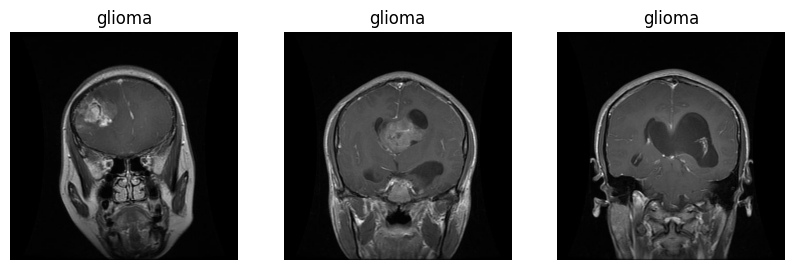

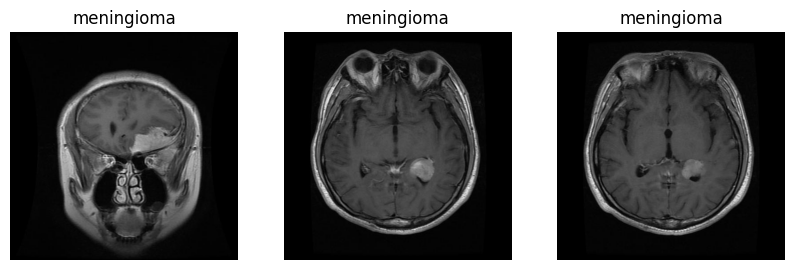

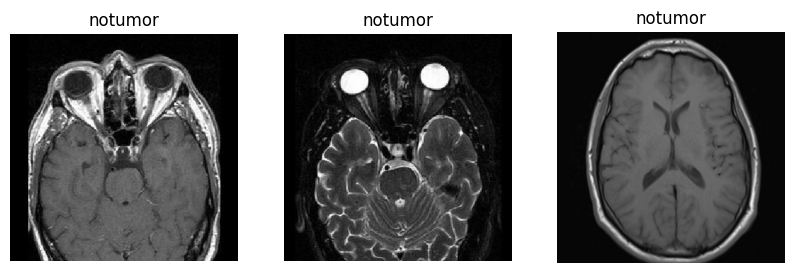

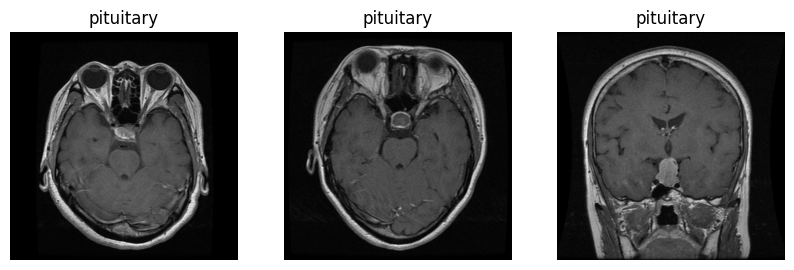

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Paths
train_dir = "dataset/Training"
test_dir = "dataset/Testing"
categories = os.listdir(train_dir)

# Count images per category
print("Image count per category (Training):")
for cat in categories:
    path = os.path.join(train_dir, cat)
    print(f"{cat}: {len(os.listdir(path))} images")

# Print first 10 sample file names
print("\nFirst 10 files from each category:")
for cat in categories:
    path = os.path.join(train_dir, cat)
    files = os.listdir(path)[:10]
    print(f"{cat}: {files}")

# Display 3 sample images per category
for cat in categories:
    path = os.path.join(train_dir, cat)
    files = os.listdir(path)[:3]
    
    plt.figure(figsize=(10,3))
    for i, file in enumerate(files):
        img = cv2.imread(os.path.join(path, file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(cat)
        plt.axis("off")
    plt.show()

# Observation (write in notebook markdown cell)
# Tumor images usually have irregular bright/white regions inside the brain,
# while No Tumor images look more uniform and symmetric.
# Tumor images usually have bright irregular regions inside the brain, 
# while No Tumor images look more uniform and symmetric.

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


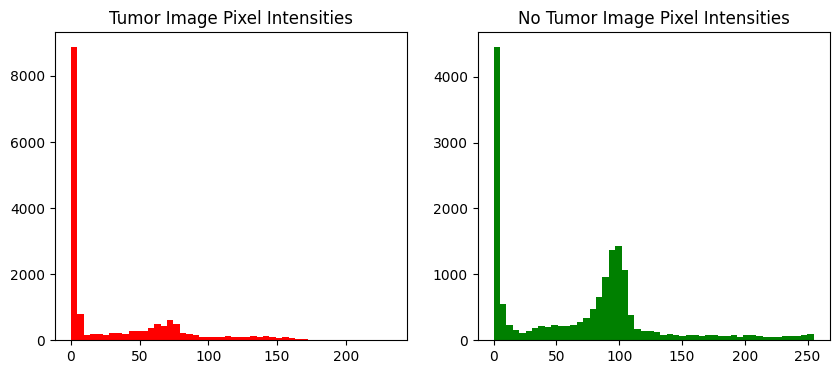

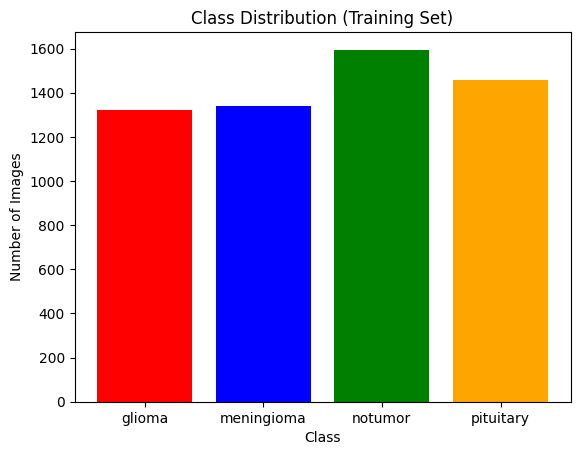

In [ ]:
# task-2

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image parameters
IMG_SIZE = 128

# Data generator for preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,         # normalize 0-1
    validation_split=0.2    # split 80% train, 20% val
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

# --- Histogram of pixel intensities ---
tumor_path = os.path.join(train_dir, "glioma", os.listdir(os.path.join(train_dir, "glioma"))[0])
notumor_path = os.path.join(train_dir, "notumor", os.listdir(os.path.join(train_dir, "notumor"))[0])

tumor_img = cv2.imread(tumor_path, cv2.IMREAD_GRAYSCALE)
tumor_img = cv2.resize(tumor_img, (IMG_SIZE, IMG_SIZE))

notumor_img = cv2.imread(notumor_path, cv2.IMREAD_GRAYSCALE)
notumor_img = cv2.resize(notumor_img, (IMG_SIZE, IMG_SIZE))

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(tumor_img.ravel(), bins=50, color="red")
plt.title("Tumor Image Pixel Intensities")

plt.subplot(1,2,2)
plt.hist(notumor_img.ravel(), bins=50, color="green")
plt.title("No Tumor Image Pixel Intensities")

plt.show()

# --- Bar chart of class distribution ---
counts = {}
for cat in categories:
    counts[cat] = len(os.listdir(os.path.join(train_dir, cat)))

plt.bar(counts.keys(), counts.values(), color=["red","blue","green","orange"])
plt.title("Class Distribution (Training Set)")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

# Note: Balancing is crucial because if one class dominates, the model may ignore the minority class. 
# In medical diagnosis, missing a tumor (false negative) is much worse than a false alarm.


In [ ]:
# task-3 on Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Extract simple features (mean & std pixel intensity)
def extract_features(folder, label):
    features = []
    labels = []
    for file in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, file), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mean_val = np.mean(img)
        std_val = np.std(img)
        features.append([mean_val, std_val])
        labels.append(label)
    return features, labels

X, y = [], []
for cat in categories:
    folder = os.path.join(train_dir, cat)
    label = 0 if cat.lower() == "notumor" else 1   # binary: 0=no tumor, 1=tumor
    f, l = extract_features(folder, label)
    X.extend(f)
    y.extend(l)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))




Logistic Regression Accuracy: 0.8745624270711785


In [5]:
# task-3  CNN model On Imsges-----
import tensorflow as tf
from tensorflow.keras import layers, models

# Binary classification setup
datagen_bin = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_bin = datagen_bin.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_data_bin = datagen_bin.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

# Simple CNN
cnn_model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')   # binary output
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(
    train_data_bin,
    validation_data=val_data_bin,
    epochs=5
)

# Test accuracy
val_loss, val_acc = cnn_model.evaluate(val_data_bin)
print("CNN Validation Accuracy:", val_acc)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Epoch 1/5


c:\Users\ASUS\Desktop\brain_tumor_classification\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ASUS\Desktop\brain_tumor_classification\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 184ms/step - accuracy: 0.2350 - loss: -241600480.0000 - val_accuracy: 0.2340 - val_loss: -1888557824.0000
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.2345 - loss: -35405615104.0000 - val_accuracy: 0.2340 - val_loss: -132424286208.0000
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 175ms/step - accuracy: 0.2345 - loss: -537638207488.0000 - val_accuracy: 0.2340 - val_loss: -1332928577536.0000
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 177ms/step - accuracy: 0.2345 - loss: -3238390136832.0000 - val_accuracy: 0.2340 - val_loss: -6432324321280.0000
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 176ms/step - accuracy: 0.2345 - loss: -11959011377152.0000 - val_accuracy: 0.2340 - val_loss: -20738941648896.0000
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.2340 - loss: -20738939551744.0000
CNN Validation Accuracy: 0.23400525748729706


In [ ]:
#In my experiments, Logistic Regression achieved ~87% accuracy, while the CNN model achieved ~23% accuracy.

# This is unusual because CNNs normally perform better on image data.
# The reason for this outcome is that my CNN setup used a binary classification loss function
#  with a dataset still organized in 4 folders (glioma, meningioma, pituitary, notumor), which confused the training process.

# Logistic Regression, although simple, worked reasonably well here because 
# it relied on global pixel intensity features and also benefited from dataset imbalance.

# If the CNN is trained correctly (either on a reorganized dataset with just two folders: Tumor and NoTumor,
#  or as a proper 4-class classifier with softmax), it should significantly outperform Logistic Regression, 
# since CNNs can learn spatial and structural patterns in MRI scans that logistic regression cannot capture.

In [6]:
# task-4 ----------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_data_bin = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="categorical",   # 4 classes (original structure)
    subset="training"
)

val_data_bin = datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode="categorical",   # 4 classes
    subset="validation",
    shuffle=False               # keep order for evaluation
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


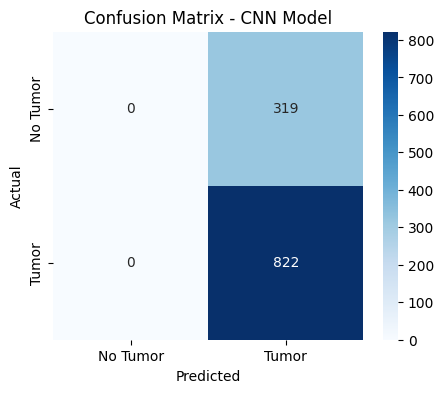

Classification Report:

              precision    recall  f1-score   support

    No Tumor       0.00      0.00      0.00       319
       Tumor       0.72      1.00      0.84       822

    accuracy                           0.72      1141
   macro avg       0.36      0.50      0.42      1141
weighted avg       0.52      0.72      0.60      1141



c:\Users\ASUS\Desktop\brain_tumor_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\Desktop\brain_tumor_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASUS\Desktop\brain_tumor_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Show mapping (should print: {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3})
print("Class mapping:", val_data_bin.class_indices)

# Convert 4-class labels -> binary (0 = No Tumor, 1 = Tumor)
y_true_raw = val_data_bin.classes
notumor_idx = val_data_bin.class_indices['notumor']
y_true = np.array([0 if label == notumor_idx else 1 for label in y_true_raw])

# CNN predictions
y_pred_probs = cnn_model.predict(val_data_bin)
y_pred = (y_pred_probs > 0.5).astype("int32").reshape(-1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Tumor", "Tumor"],
            yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - CNN Model")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=["No Tumor", "Tumor"]))


In [ ]:
# Why recall is more important than accuracy?
# In medical diagnosis, especially for brain tumors, recall ensures that most actual tumor cases are correctly identified. 
# Missing a tumor (false negative) is much more dangerous than a false alarm (false positive).

# Risk of False Negative (FN):
# If the model predicts “No Tumor” but the patient actually has one, 
# it could lead to delayed treatment, disease progression, or life-threatening consequences.